# Setup & Data loading

In [57]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [58]:
df = pd.read_csv("hate_speech_dataset.tsv")
df["cleaned_post"] = df["cleaned_post"].astype(str)

print(df["class"].value_counts())
print(df["bi_class"].value_counts())
print(df["mul_class"].value_counts())

df.drop(df[df["class"] == "explicit_hate"].index, inplace=True)
df["binary"] = (df["class"] == "implicit_hate").astype(int)
print(df["binary"].value_counts())


class
not_hate         13270
implicit_hate     7094
explicit_hate     1086
Name: count, dtype: int64
bi_class
0    13270
1     8180
Name: count, dtype: int64
mul_class
0    13270
1     7094
2     1086
Name: count, dtype: int64
binary
0    13270
1     7094
Name: count, dtype: int64


# Train/Test split

In [59]:
X = df["cleaned_post"].values
y = df["binary"].values.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)


print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 16291
Test size: 4073


In [60]:
train_df = pd.DataFrame({
    "text": X_train,
    "label": y_train
})

train_min = train_df[train_df["label"] == 1]   # implicit
train_maj = train_df[train_df["label"] == 0]   # not-hate

n_min = len(train_min)
print("Train minority (implicit) size:", n_min)
print("Train majority (not_hate) size:", len(train_maj))

train_maj_down = train_maj.sample(n=n_min, random_state=42)

train_bal = pd.concat([train_min, train_maj_down]).sample(frac=1, random_state=42)

X_train_bal = train_bal["text"].values
y_train_bal = train_bal["label"].values

print("\nBalanced train label counts (1:1):")
print(pd.Series(y_train_bal).value_counts())


Train minority (implicit) size: 5675
Train majority (not_hate) size: 10616

Balanced train label counts (1:1):
0    5675
1    5675
Name: count, dtype: int64


To mitigate the severe class imbalance, we downsample the training data to a 1:1 implicit-to-non-hate ratio.
The test set remains untouched and preserves the real-world distribution (~1:2), which ensures that our evaluation reflects actual deployment conditions rather than an artificially balanced setting.
This design is standard practice in imbalanced learning and allows the model to learn the minority signal while still being evaluated realistically.

# Baseline Model: Naive Bayers + TF-IDF


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb_1 = nb_model.predict(X_test_tfidf)


In [62]:
X_train_bal_tfidf = tfidf.fit_transform(X_train_bal)
X_test_bal_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_bal_tfidf, y_train_bal)
y_pred_nb_2 = nb_model.predict(X_test_bal_tfidf)

Naive Bayes (Implicit vs Not Hate) Report:
              precision    recall  f1-score   support

           0     0.7075    0.9570    0.8136      2654
           1     0.7640    0.2600    0.3880      1419

    accuracy                         0.7142      4073
   macro avg     0.7357    0.6085    0.6008      4073
weighted avg     0.7272    0.7142    0.6653      4073



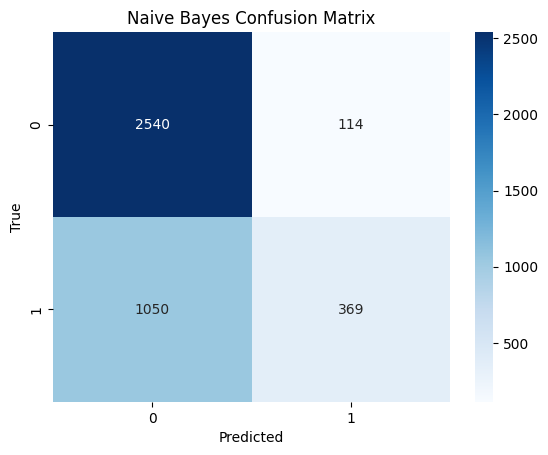

In [63]:
print("Naive Bayes (Implicit vs Not Hate) Report:")
print(classification_report(y_test, y_pred_nb_1, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Naive Bayes (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.8177    0.6458    0.7217      2654
           1     0.5245    0.7308    0.6107      1419

    accuracy                         0.6754      4073
   macro avg     0.6711    0.6883    0.6662      4073
weighted avg     0.7156    0.6754    0.6830      4073



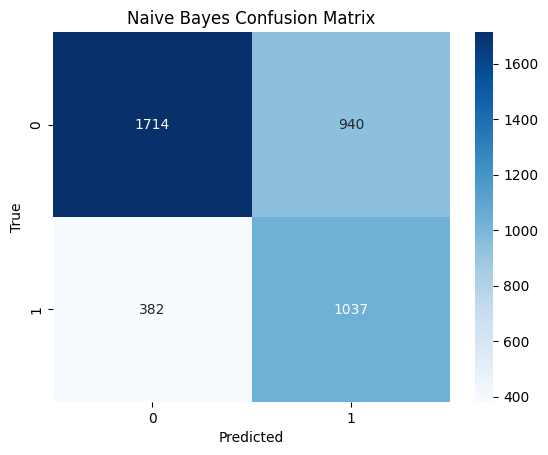

In [64]:
print("Naive Bayes (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(y_test, y_pred_nb_2, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_2)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The Naive Bayes baseline performs well at identifying the majority “other” class, achieving a very high recall of 0.95. However, its performance on implicit hate — the minority class — is extremely weak. Although precision for class 1 is moderate (0.75), recall drops to only 0.26, meaning the model misses more than 80% of implicit hate examples. This indicates that Naive Bayes relies heavily on surface-level lexical cues and cannot capture the subtle, context-dependent patterns that characterize implicit hate. As a result, the model is strongly biased toward predicting the majority class, leading to poor macro-F1 and ineffective minority-class detection.

**Although downsampling improves the recall of the implicit hate class, it comes at the cost of a substantial drop in overall accuracy (from 0.71 to 0.67).**

# Model 2: RNN - LSTM

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

## Model Building

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC

# class weight(for imbalanced data)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}


In [67]:
EMBED_DIM = 100
LSTM_UNITS = 64

inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


### Train without class_weight

In [68]:
# train without class weight
history_rnn_1 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_1 = bilstm_model.predict(X_test_pad)
y_pred_1 = (y_pred_1 >= 0.5).astype("int32").ravel()

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6600 - auc: 0.5932 - loss: 0.6295 - precision: 0.4990 - recall: 0.0856 - val_accuracy: 0.7245 - val_auc: 0.7600 - val_loss: 0.5445 - val_precision: 0.6370 - val_recall: 0.4806
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7773 - auc: 0.8382 - loss: 0.4658 - precision: 0.7103 - recall: 0.6034 - val_accuracy: 0.7086 - val_auc: 0.7475 - val_loss: 0.5901 - val_precision: 0.5870 - val_recall: 0.5424
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8476 - auc: 0.9158 - loss: 0.3476 - precision: 0.8017 - recall: 0.7445 - val_accuracy: 0.6798 - val_auc: 0.7256 - val_loss: 0.6860 - val_precision: 0.5406 - val_recall: 0.5177
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Train with class_weight

In [69]:
history_rnn_2 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)
y_pred_2 = bilstm_model.predict(X_test_pad)
y_pred_2 = (y_pred_2 >= 0.5).astype("int32").ravel()

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7698 - auc: 0.8423 - loss: 0.4898 - precision: 0.6431 - recall: 0.7565 - val_accuracy: 0.6877 - val_auc: 0.7426 - val_loss: 0.6389 - val_precision: 0.5427 - val_recall: 0.6396
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8280 - auc: 0.9085 - loss: 0.3801 - precision: 0.7146 - recall: 0.8414 - val_accuracy: 0.6613 - val_auc: 0.7241 - val_loss: 0.7344 - val_precision: 0.5104 - val_recall: 0.6060
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8822 - auc: 0.9518 - loss: 0.2762 - precision: 0.7911 - recall: 0.8977 - val_accuracy: 0.6466 - val_auc: 0.7078 - val_loss: 0.8988 - val_precision: 0.4926 - val_recall: 0.5866
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Downsampling

In [70]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_bal)

X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_bal_seq = tokenizer.texts_to_sequences(X_test)

X_train_bal_pad = pad_sequences(X_train_bal_seq, maxlen=MAX_LEN)
X_test_bal_pad = pad_sequences(X_test_bal_seq, maxlen=MAX_LEN)


In [71]:
inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train without class weight
history_rnn_3 = bilstm_model.fit(
    X_train_bal_pad, y_train_bal,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_3 = bilstm_model.predict(X_test_bal_pad)
y_pred_3 = (y_pred_3 >= 0.5).astype("int32").ravel()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5578 - auc: 0.5822 - loss: 0.6776 - precision: 0.5549 - recall: 0.6836 - val_accuracy: 0.6837 - val_auc: 0.7464 - val_loss: 0.5989 - val_precision: 0.6830 - val_recall: 0.6720
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7512 - auc: 0.8302 - loss: 0.5071 - precision: 0.7542 - recall: 0.7532 - val_accuracy: 0.6696 - val_auc: 0.7366 - val_loss: 0.6704 - val_precision: 0.6550 - val_recall: 0.7005
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8364 - auc: 0.9179 - loss: 0.3643 - precision: 0.8400 - recall: 0.8355 - val_accuracy: 0.6396 - val_auc: 0.7178 - val_loss: 0.8589 - val_precision: 0.6230 - val_recall: 0.6863
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Evaluation

### Training curve

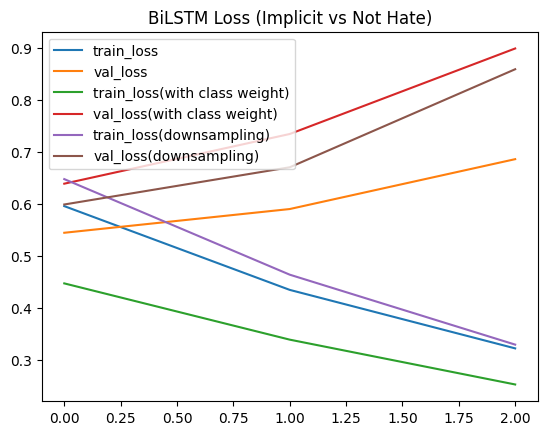

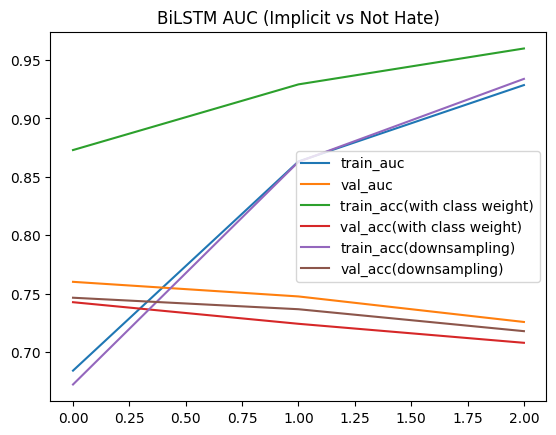

In [72]:
plt.plot(history_rnn_1.history['loss'], label='train_loss')
plt.plot(history_rnn_1.history['val_loss'], label='val_loss')
plt.plot(history_rnn_2.history['loss'], label='train_loss(with class weight)')
plt.plot(history_rnn_2.history['val_loss'], label='val_loss(with class weight)')
plt.plot(history_rnn_3.history['loss'], label='train_loss(downsampling)')
plt.plot(history_rnn_3.history['val_loss'], label='val_loss(downsampling)')
plt.legend()
plt.title("BiLSTM Loss (Implicit vs Not Hate)")
plt.show()

plt.plot(history_rnn_1.history["auc"], label="train_auc")
plt.plot(history_rnn_1.history["val_auc"], label="val_auc")
plt.plot(history_rnn_2.history['auc'], label='train_acc(with class weight)')
plt.plot(history_rnn_2.history['val_auc'], label='val_acc(with class weight)')
plt.plot(history_rnn_3.history['auc'], label='train_acc(downsampling)')
plt.plot(history_rnn_3.history['val_auc'], label='val_acc(downsampling)')
plt.legend()
plt.title("BiLSTM AUC (Implicit vs Not Hate)")
plt.show()


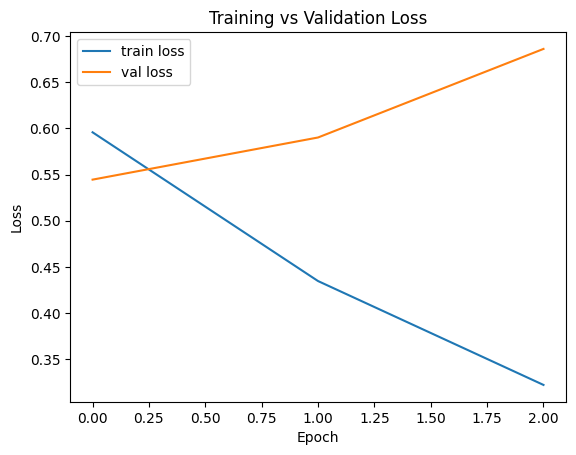

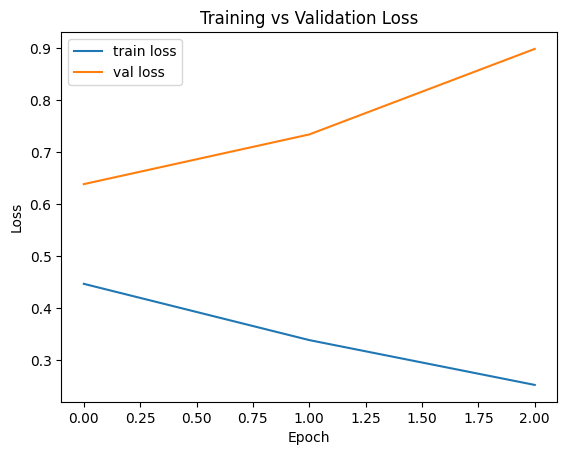

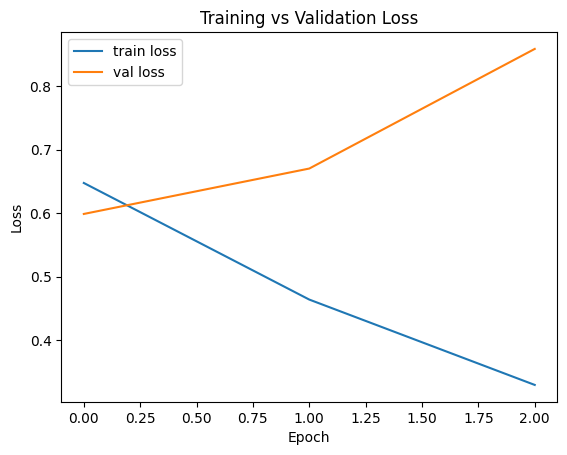

In [73]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


plot_train_val_loss(history_rnn_1)
plot_train_val_loss(history_rnn_2)
plot_train_val_loss(history_rnn_3)

The training and validation curves diverge very early (around 0.2–0.3 epoch), indicating that the model begins to overfit almost immediately.
This is expected given the small dataset size and the subtle nature of implicit hate.
Therefore, we rely on early stopping rather than manually tuning the epoch count, as training for a full epoch already exceeds the optimal point.

BiLSTM (Implicit vs Not Hate) Report(without class weight):
              precision    recall  f1-score   support

           0     0.7575    0.8651    0.8077      2654
           1     0.6564    0.4820    0.5559      1419

    accuracy                         0.7316      4073
   macro avg     0.7070    0.6736    0.6818      4073
weighted avg     0.7223    0.7316    0.7200      4073



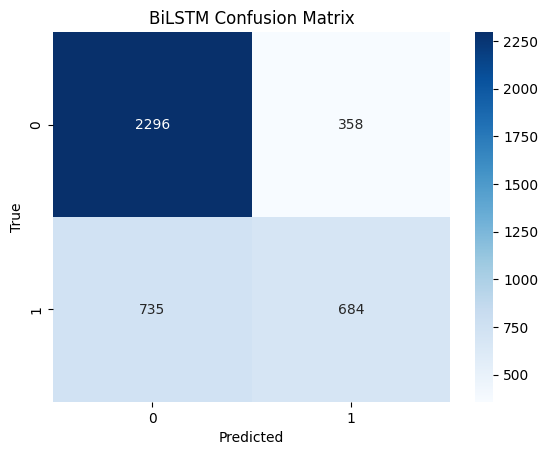

In [74]:
print("BiLSTM (Implicit vs Not Hate) Report(without class weight):")
print(classification_report(y_test, y_pred_1, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Not Hate) Report(with class weight):
              precision    recall  f1-score   support

           0     0.7911    0.7265    0.7574      2654
           1     0.5562    0.6413    0.5957      1419

    accuracy                         0.6968      4073
   macro avg     0.6737    0.6839    0.6766      4073
weighted avg     0.7093    0.6968    0.7011      4073



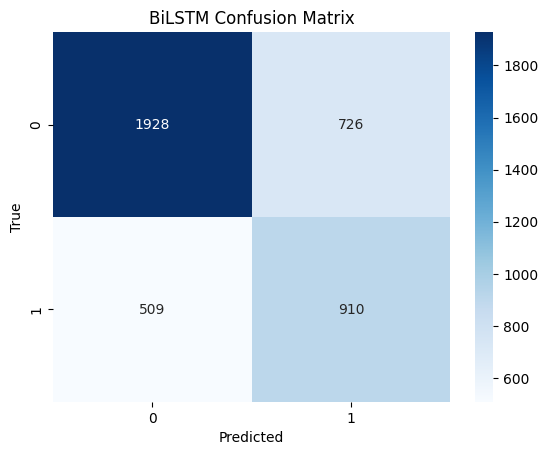

In [75]:
print("BiLSTM (Implicit vs Not Hate) Report(with class weight):")
print(classification_report(y_test, y_pred_2, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.7940    0.7246    0.7577      2654
           1     0.5572    0.6483    0.5993      1419

    accuracy                         0.6980      4073
   macro avg     0.6756    0.6865    0.6785      4073
weighted avg     0.7115    0.6980    0.7025      4073



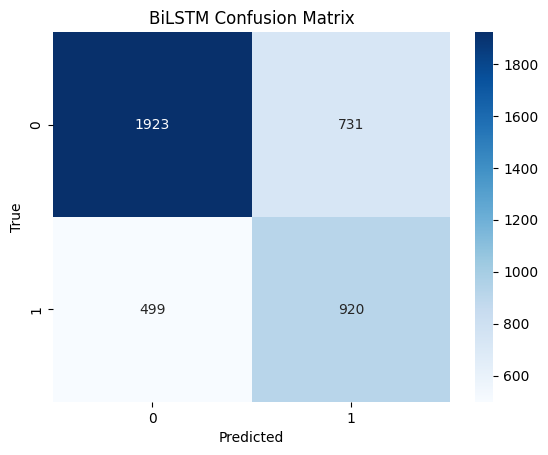

In [76]:
print("BiLSTM (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(y_test, y_pred_3, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_3)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Applying class weights improves the model’s ability to detect implicit hate — the minority class — by substantially increasing recall (from 0.46 to 0.64) and improving the F1 score for class 1. This indicates that the baseline model was strongly biased toward the majority “other” class, and class weighting helps correct this imbalance by encouraging the network to pay more attention to subtle hateful content.

The overall accuracy drops slightly, which is expected: increasing sensitivity to minority samples comes at the cost of misclassifying more majority-class examples. However, for this task, detecting implicit hate is more important than optimizing global accuracy.

In summary, class weighting provides a meaningful but limited improvement — a step in the right direction, but insufficient on its own. The task remains challenging, and more advanced models (e.g., BERT) are likely required to capture deeper contextual cues.

Possible Reasons:

1. Implicit hate rarely contains explicit lexical cues
2. RNNs struggle with long-range or abstract semantic dependencies
3. Data imbalance amplifies RNN weaknesses
4. Vocabulary-based sequence models cannot detect paraphrasing or contextual shifts
5. Overfitting occurs easily due to small dataset + high model capacity

**Downsample and class_wight produce similar results for LSTM.**

# Model 3: BERT

## Setup

In [77]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [78]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Implicit vs Not Hate
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Data Preparation

In [79]:
class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),       # (seq_len)
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


In [80]:
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = HateDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
test_dataset  = HateDataset(X_test,  y_test,  tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


In [81]:
train_bal_dataset = HateDataset(X_train_bal, y_train_bal, tokenizer, max_len=MAX_LEN)
train_bal_loader = DataLoader(train_bal_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model Training

### no class weight

In [82]:
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")


Epoch 1/3 - train loss: 0.5430
Epoch 2/3 - train loss: 0.4370
Epoch 3/3 - train loss: 0.3180


In [83]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds_1  = np.concatenate(all_preds)
all_labels_1 = np.concatenate(all_labels)

print("BERT (Implicit vs Not Hate) Report:")
print(classification_report(all_labels_1, all_preds_1, digits=4))

cm_bert_1 = confusion_matrix(all_labels_1, all_preds_1)
print("Confusion Matrix:\n", cm_bert_1)


BERT (Implicit vs Not Hate) Report:
              precision    recall  f1-score   support

           0     0.8166    0.7766    0.7961      2654
           1     0.6172    0.6737    0.6442      1419

    accuracy                         0.7407      4073
   macro avg     0.7169    0.7251    0.7201      4073
weighted avg     0.7471    0.7407    0.7432      4073

Confusion Matrix:
 [[2061  593]
 [ 463  956]]


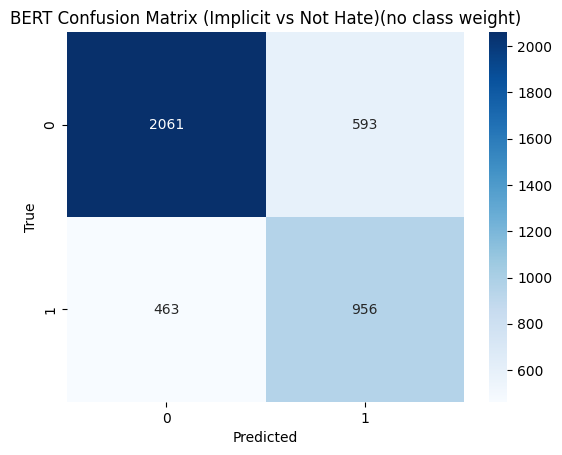

In [84]:
sns.heatmap(cm_bert_1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)(no class weight)")
plt.show()

### With class weight

In [85]:
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [86]:
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")


Epoch 1/3 - train loss: 0.2046
Epoch 2/3 - train loss: 0.1310
Epoch 3/3 - train loss: 0.0971


In [87]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds_2  = np.concatenate(all_preds)
all_labels_2 = np.concatenate(all_labels)

print("BERT (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(all_labels_2, all_preds_2, digits=4))

cm_bert_2 = confusion_matrix(all_labels_2, all_preds_2)
print("Confusion Matrix:\n", cm_bert_2)

BERT (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.8306    0.7148    0.7683      2654
           1     0.5769    0.7273    0.6434      1419

    accuracy                         0.7191      4073
   macro avg     0.7037    0.7210    0.7059      4073
weighted avg     0.7422    0.7191    0.7248      4073

Confusion Matrix:
 [[1897  757]
 [ 387 1032]]


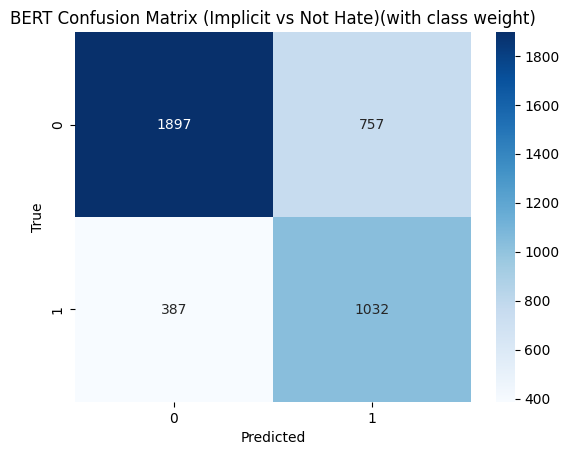

In [88]:
sns.heatmap(cm_bert_2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)(with class weight)")
plt.show()

### Downsampling

In [89]:
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_bal_loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")


Epoch 1/3 - train loss: 0.0522
Epoch 2/3 - train loss: 0.0383
Epoch 3/3 - train loss: 0.0321


In [90]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds_3  = np.concatenate(all_preds)
all_labels_3 = np.concatenate(all_labels)

print("BERT (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(all_labels_3, all_preds_3, digits=4))

cm_bert_3 = confusion_matrix(all_labels_3, all_preds_3)
print("Confusion Matrix:\n", cm_bert_3)


BERT (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.8056    0.7792    0.7922      2654
           1     0.6109    0.6483    0.6291      1419

    accuracy                         0.7336      4073
   macro avg     0.7082    0.7138    0.7106      4073
weighted avg     0.7378    0.7336    0.7354      4073

Confusion Matrix:
 [[2068  586]
 [ 499  920]]


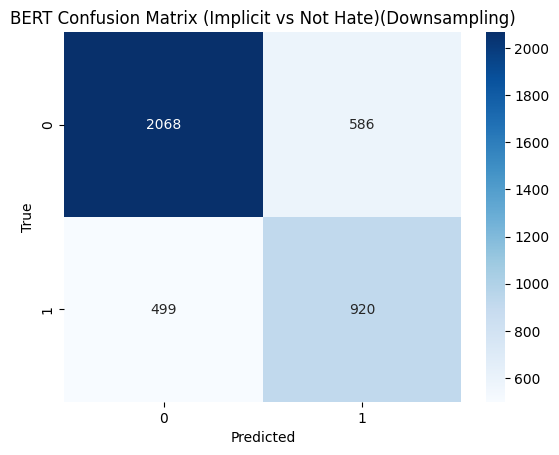

In [91]:
sns.heatmap(cm_bert_3, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)(Downsampling)")
plt.show()

# Final Evaluation

## Original Dataset(with class weight)

### ROC Curve

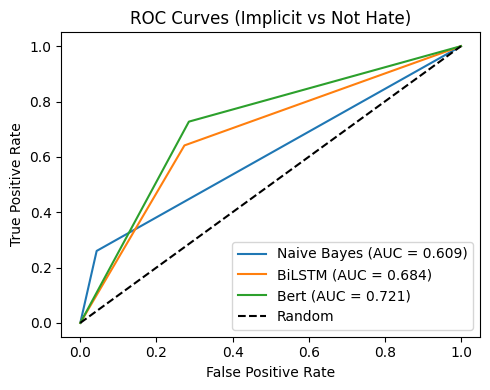

In [92]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, prob_dict):
    """
    """
    plt.figure(figsize=(5, 4))
    for name, y_pred in prob_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Implicit vs Not Hate)")
    plt.legend()
    plt.tight_layout()
    plt.show()

pred_dict = {
    "Naive Bayes": y_pred_nb_1,
    "BiLSTM": y_pred_2,
    "Bert": all_preds_2,
}
plot_roc_curves(y_test, pred_dict)

### PR Curve

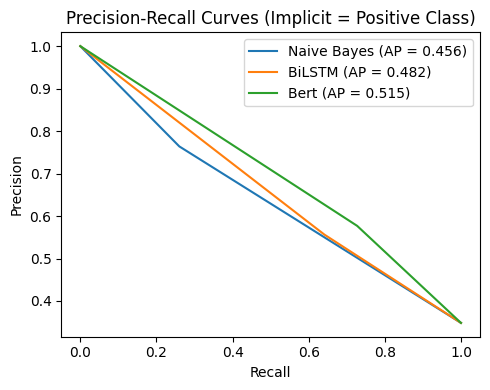

In [93]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_true, pred_dict):
    plt.figure(figsize=(5, 4))
    for name, y_pred in pred_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
        ap = average_precision_score(y_true, y_pred)
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Implicit = Positive Class)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pr_curves(y_test, pred_dict)

### Error Example

In [94]:
test_df = pd.DataFrame({
    "text": X_test,
    "label": y_test,
})

def get_error_examples(df, y_true, y_pred, text_col="text"):
    df = df.copy()
    df["y_true"] = y_true
    df["y_pred"] = y_pred

    # False Negatives
    fn = df[(df["y_true"] == 1) & (df["y_pred"] == 0)]

    # False Positives
    fp = df[(df["y_true"] == 0) & (df["y_pred"] == 1)]

    return fn, fp

fn_nb, fp_nb       = get_error_examples(test_df, y_test, y_pred_nb_1)
fn_rnn, fp_rnn     = get_error_examples(test_df, y_test, y_pred_2)
fn_bert, fp_bert     = get_error_examples(test_df, y_test, all_preds_2)



In [95]:
def show_examples(df, n=5, title="Examples"):
    print(f"\n===== {title} (n={min(n, len(df))}) =====")
    for i, row in df.sample(min(n, len(df)), random_state=42).iterrows():
        print(f"[true={row['y_true']}, pred={row['y_pred']}]")
        print(row["text"])
        print("-" * 50)

show_examples(fn_bert, n=5, title="BERT False Negatives")
show_examples(fp_bert, n=5, title="BERT False Positives")

show_examples(fn_nb,  n=3, title="NB False Negatives")
show_examples(fp_nb,  n=3, title="NB False Positives")

show_examples(fn_rnn, n=3, title="BiLSTM False Negatives")
show_examples(fp_rnn, n=3, title="BiLSTM False Positives")



===== BERT False Negatives (n=5) =====
[true=1, pred=0]
wanna hear favorite oximoron black people
--------------------------------------------------
[true=1, pred=0]
white race rich want free lunches
--------------------------------------------------
[true=1, pred=0]
diverstiy code word white genocide
--------------------------------------------------
[true=1, pred=0]
sin nature unregenerate
--------------------------------------------------
[true=1, pred=0]
white head breitbart
--------------------------------------------------

===== BERT False Positives (n=5) =====
[true=0, pred=1]
brutal black white abduction murder little white girl ms
--------------------------------------------------
[true=0, pred=1]
muslims continue test legal waters longer need accused muslim
--------------------------------------------------
[true=0, pred=1]
pl request mr pass global decree restrict population children couple spouse countries
--------------------------------------------------
[true=0, pred=1

On the original, highly imbalanced data, even BERT struggles to capture implicit hate reliably.
When we rebalance the training set via undersampling, BERT’s recall on implicit hate increases substantially, but this comes at the cost of more false positives and reduced exposure to the full diversity of non-hate language.